In [1]:
from resnet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [14]:
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
SEED = 2809
SAVE_STATE_PATH = "Model_Saves/residual_network.pt"

In [3]:
torch.manual_seed(SEED)

In [4]:
train_set = torchvision.datasets.MNIST(
    root='data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.MNIST(
    root='data/',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

data_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=128)

In [5]:
train_idx, val_idx = train_test_split(range(data_loader.dataset.targets.shape[0]), test_size=0.2, stratify=data_loader.dataset.targets, random_state=SEED)

In [6]:
train_dataloader = DataLoader(data_loader.dataset, batch_size=128, sampler=train_idx)
val_dataloader = DataLoader(data_loader.dataset, batch_size=128, sampler=val_idx)

In [7]:
model = ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

c:\Kyode\clg\DL_Assignments\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNet(
  (conv1): LazyConv2d(0, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): LazyConv2d(0, 20, kernel_size=(2, 2), stride=(1, 1))
  (downsample): LazyConv2d(0, 20, kernel_size=(7, 7), stride=(2, 2), bias=False)
  (fc1): LazyLinear(in_features=0, out_features=50, bias=True)
  (out): LazyLinear(in_features=0, out_features=10, bias=True)
)

In [8]:
train_samples, val_samples = 0, 0

for i in train_dataloader:
    train_samples += i[-1].shape[0]

for i in val_dataloader:
    val_samples += i[-1].shape[0]

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("training...")

train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(NUM_EPOCHS):
    t_loss = 0
    v_loss = 0
    train_total_correct = 0
    val_total_correct = 0

    for batch in train_dataloader:
        X, labels = batch

        X = X.cuda()
        labels = labels.cuda()

        preds = model(X)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += loss.item()
        train_total_correct += get_num_correct(preds, labels)
    
    print("\n------ Evaluating on Validation Set ------\n")
    with torch.no_grad():
        for batch in val_dataloader:
            X, labels = batch

            X = X.cuda()
            labels = labels.cuda()

            preds = model(X)
            loss = criterion(preds, labels)

            v_loss += loss.item()
            val_total_correct += get_num_correct(preds, labels)
    
    train_loss.append(t_loss / train_samples)
    val_loss.append(v_loss / val_samples)

    train_accuracy.append(100*train_total_correct / train_samples)
    val_accuracy.append(100*val_total_correct / val_samples)

    print('Epoch: {} of {}, Training Loss: {:.4f}, Training Accuracy: {:.4f}'.format(epoch+1, NUM_EPOCHS, train_loss[-1], train_accuracy[-1]))
    print('\t\tValidation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(val_loss[-1], val_accuracy[-1]))

training...

------ Evaluating on Validation Set ------

Epoch: 1 of 10, Training Loss: 0.0170, Training Accuracy: 37.2375
		Validation Loss: 0.0154, Validation Accuracy: 55.8083

------ Evaluating on Validation Set ------

Epoch: 2 of 10, Training Loss: 0.0144, Training Accuracy: 67.6104
		Validation Loss: 0.0138, Validation Accuracy: 73.6083

------ Evaluating on Validation Set ------

Epoch: 3 of 10, Training Loss: 0.0132, Training Accuracy: 81.1479
		Validation Loss: 0.0130, Validation Accuracy: 82.8167

------ Evaluating on Validation Set ------

Epoch: 4 of 10, Training Loss: 0.0129, Training Accuracy: 83.2958
		Validation Loss: 0.0128, Validation Accuracy: 84.1333

------ Evaluating on Validation Set ------

Epoch: 5 of 10, Training Loss: 0.0128, Training Accuracy: 84.2167
		Validation Loss: 0.0128, Validation Accuracy: 84.7167

------ Evaluating on Validation Set ------

Epoch: 6 of 10, Training Loss: 0.0127, Training Accuracy: 84.7188
		Validation Loss: 0.0127, Validation Accu

In [10]:
print("\n------ Inference on Test Set ------\n")
test_loss = 0
test_total_correct = 0
with torch.no_grad():
    for batch in test_dataloader:
        X, labels = batch

        X = X.cuda()
        labels = labels.cuda()

        preds = model(X)
        loss = criterion(preds, labels)

        test_loss += loss.item()
        test_total_correct += get_num_correct(preds, labels)

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss / len(test_dataloader.dataset), 100*test_total_correct / len(test_dataloader.dataset)))


------ Inference on Test Set ------

Test Loss: 0.0126, Test Accuracy: 86.7300


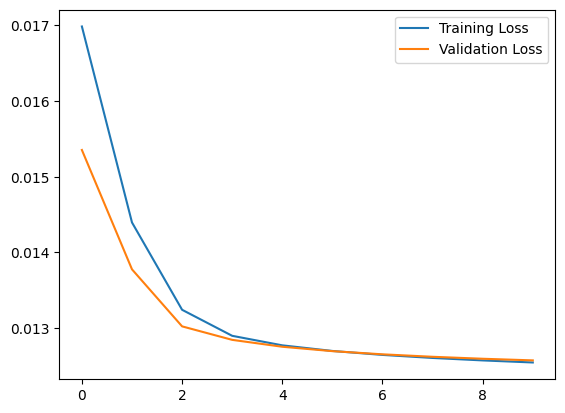

In [11]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

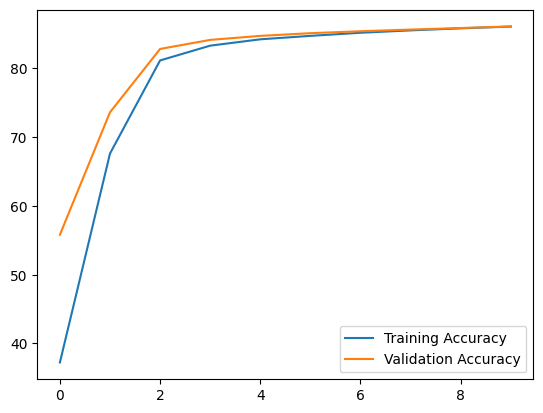

In [12]:
# Plot training and validation accuracy in the same plot

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()

In [15]:
torch.save(model.state_dict(), SAVE_STATE_PATH)

#### Loading Saved Model

In [16]:
model = ResNet()
model.load_state_dict(torch.load(SAVE_STATE_PATH))

c:\Kyode\clg\DL_Assignments\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>